In this notebook, we train our DualEncoder-FNO model.

(IN PROGRESS)

### 1. Libraries

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler

import os
from pathlib import Path

from rve_analyzer import RVEDataset, DualEncoderFNO, Trainer

### 2. Configuration

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [20]:
h5_path = Path("./master_data/rve_run1.h5")
batch_size = 16
num_workers = 8 if torch.cuda.is_available() else 0
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

### 3. Datasets & DataLoader

In [21]:
train_dataset = RVEDataset(h5_path, split='train')
val_dataset   = RVEDataset(h5_path, split='val')
test_dataset  = RVEDataset(h5_path, split='test')

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# Get dimensions
sample_xl, sample_xg, sample_y = train_dataset[0]
in_channels = sample_xl.shape[0]      # phase + nstatev + ...
out_channels = sample_y.shape[0]
nmacro = sample_xg.shape[0]

print(f"in_channels={in_channels}, out_channels={out_channels}, nmacro={nmacro}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

Train: 600 | Val: 200 | Test: 200
in_channels=1, out_channels=3, nmacro=7


In [22]:
   
# Test one batch
for x_local, x_global, y_local in train_loader:
        print(f"x_local shape : {x_local.shape}")   # (B, 96, 96, 1)
        print(f"x_global shape: {x_global.shape}")  # (B, 7)
        print(f"y_local shape : {y_local.shape}")   # (B, 96, 96, 3)
        break

x_local shape : torch.Size([16, 1, 96, 96])
x_global shape: torch.Size([16, 7])
y_local shape : torch.Size([16, 3, 96, 96])


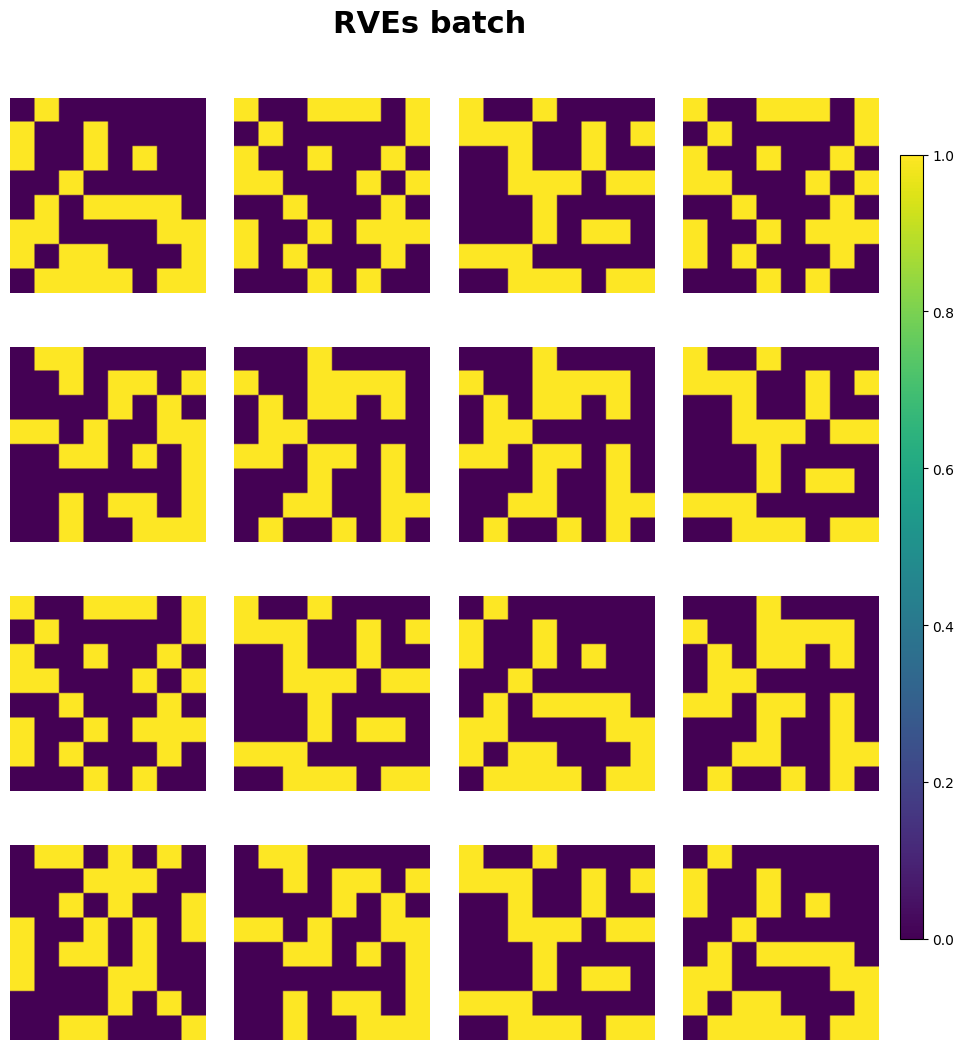

In [24]:
def show_phase_batch(dataloader, 
                     title="RVEs batch", 
                     max_images=32, 
                     nrow=8, 
                     wspace=0.15,
                     hspace=0.15,
                     ):

    x_local, _, _ = next(iter(dataloader))
    # Channel 0 → phase (B, 1, H, W)
    x_local = x_local[:, 0:1].cpu()
    
    # Normalization Min-Max [0,1]
    x_min = x_local.min()
    x_max = x_local.max()
    x_vis = (x_local - x_min) / (x_max - x_min + 1e-8)
    
    n_images = min(max_images, x_vis.shape[0])
    x_vis = x_vis[:n_images]
    
    # Grid
    nrow = min(nrow, int(np.ceil(np.sqrt(n_images))))
    ncol = int(np.ceil(n_images / nrow))
    
    fig = plt.figure(figsize=(nrow*2.8, ncol*2.8), facecolor='white')
    fig.suptitle(title, fontsize=22, y=0.98, fontweight='bold')
    
    # Subplots
    gs = fig.add_gridspec(nrow, ncol, wspace=wspace, hspace=hspace)
    
    for idx in range(n_images):
        ax = fig.add_subplot(gs[idx // ncol, idx % ncol])

        im = ax.imshow(x_vis[idx, 0].numpy(), cmap='viridis', vmin=0, vmax=1)
        
        ax.set_facecolor('white')
        ax.axis('off')
    
    # Ajuste final y barra de color compartida
    fig.subplots_adjust(top=.91, bottom=0.05)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax,)
    
    plt.show()


show_phase_batch(train_loader, 
                 max_images=32,
                 nrow=8,
                 )

In [ ]:
from neuralop.utils import count_model_params

n_params = count_model_params(model)
print(f"\nOur model has {n_params} parameters.")